In [95]:
# import libraries
import pandas as pd
import numpy as np

import yfinance as yf

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint 
from statsmodels.regression.rolling import RollingOLS

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

import warnings
warnings.filterwarnings("ignore")

# Load environment variables
from dotenv import load_dotenv
import os
from pathlib import Path

# Load .env file from general directory (using relative path from current working directory)
env_path = Path('../../general/.env')
load_dotenv(env_path)

True

In [96]:
# data downloading and reading

# forex pairs
symbol_list = [
    'EURUSD=X',
    'EURAUD=X',
    'AUDUSD=X',
    'NZDJPY=X',
    'AUDJPY=X',
    'CHFJPY=X',
    'USDCHF=X',
    'CADJPY=X'
]

# # set the dates range
# start_date = '2020-01-01'
# end_date = dt.datetime.now().strftime('%Y-%m-%d')

# # download data
# data = yf.download(symbol_list, 
#                    start=start_date, 
#                    end=end_date)

# Get data path from environment variables
data_path_forex = os.getenv('data_path_forex')

# # save data to csv
# data.to_csv(os.path.join(data_path_forex, 'forex_data.csv'))

# load data from csv
data = pd.read_csv(os.path.join(data_path_forex, 'forex_data.csv'))

# # data
# data.head()

In [97]:
# data cleaning
# rename Price column to Date and set it as index
data.rename(columns={'Price': 'Date'}, inplace=True)

# Drop second row (contains NaN)
data.drop(index=1, inplace=True)

# Extract ticker information from row 0
ticker_row = data.iloc[0].tolist()

# Create tuples for MultiIndex (price_type, ticker)
multi_index_tuples = []
current_columns = data.columns.tolist()

for i, col in enumerate(current_columns):
    # Handle case where col might be a tuple (if MultiIndex already exists)
    col_name = col[0] if isinstance(col, tuple) else col
    
    if i == 0:  # First column is Date
        multi_index_tuples.append(('Date', ''))
    else:
        # Map column to price type and ticker
        if col_name.startswith('Close'):
            price_type = 'Close'
        elif col_name.startswith('High'):
            price_type = 'High'
        elif col_name.startswith('Low'):
            price_type = 'Low'
        elif col_name.startswith('Open'):
            price_type = 'Open'
        elif col_name.startswith('Volume'):
            price_type = 'Volume'
        else:
            price_type = col_name
        
        # Get corresponding ticker
        ticker = ticker_row[i] if i < len(ticker_row) else ''
        multi_index_tuples.append((price_type, ticker))

# Create MultiIndex
data.columns = pd.MultiIndex.from_tuples(multi_index_tuples, names=['Price_Type', 'Ticker'])

# Remove the ticker row (row 0) since it's now in the MultiIndex
data = data.drop(index=0).reset_index(drop=True)

# Convert Date column to datetime
data[('Date', '')] = pd.to_datetime(data[('Date', '')])

# Set Date as index
data.set_index(('Date', ''), inplace=True)
data.index.name = 'Date'

# Keep only Close prices
data = data['Close']

# Clean ticker names (remove =X)
data.columns = data.columns.str.replace('=X', '', regex=False)

# Convert data types to float
data = data.astype(float)

data.head()

Ticker,AUDJPY,AUDUSD,CADJPY,CHFJPY,EURAUD,EURUSD,NZDJPY,USDCHF
Date,,,,,,,,
2020-01-01,76.209999,0.701700,84.210999,112.639999,1.59930,1.122083,73.169998,0.96720
2020-01-02,76.302002,0.701951,83.760002,112.311996,1.59819,1.122083,73.222000,0.96750
2020-01-03,75.795998,0.698519,83.589996,111.699997,1.59944,1.117144,72.709999,0.97120
2020-01-06,74.964996,0.694420,83.115997,111.121002,1.60723,1.116196,71.835999,0.97148
2020-01-07,75.195999,0.693731,83.615997,111.938026,1.61375,1.119799,72.282997,0.96850


In [98]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [99]:
# Time Series Split for Pairs Trading
# For financial time series, we use temporal split instead of random split
# This preserves the time order and avoids look-ahead bias

def temporal_split(data, train_ratio=0.7):
    """
    Split time series data temporally (chronologically)
    
    Parameters:
    data: DataFrame with time series data
    train_ratio: proportion of data to use for training (default 70%)
    
    Returns:
    train_data: DataFrame with training period data
    test_data: DataFrame with testing period data
    split_date: the date where split occurs
    """
    n_train = int(len(data) * train_ratio)
    train_data = data.iloc[:n_train]
    test_data = data.iloc[n_train:]
    split_date = data.index[n_train-1] if n_train > 0 else data.index[0]
    
    print(f"Total observations: {len(data)}")
    print(f"Training period: {data.index[0]} to {split_date} ({len(train_data)} observations)")
    print(f"Testing period: {data.index[n_train]} to {data.index[-1]} ({len(test_data)} observations)")
    print(f"Train ratio: {len(train_data)/len(data):.1%}")
    
    return train_data, test_data, split_date

# Split the forex data temporally
train_data, test_data, split_date = temporal_split(data, train_ratio=0.7)

Total observations: 1455
Training period: 2020-01-01 00:00:00 to 2023-11-24 00:00:00 (1018 observations)
Testing period: 2023-11-27 00:00:00 to 2025-08-01 00:00:00 (437 observations)
Train ratio: 70.0%


In [100]:
# Step 1: Find cointegrated pairs using TRAINING data only
# This prevents look-ahead bias in the strategy
scores_train, pvalues_train, pairs_train = find_cointegrated_pairs(train_data)

print("=== TRAINING PERIOD COINTEGRATION ANALYSIS ===")
print(f"Analysis period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Number of observations: {len(train_data)}")

=== TRAINING PERIOD COINTEGRATION ANALYSIS ===
Analysis period: 2020-01-01 00:00:00 to 2023-11-24 00:00:00
Number of observations: 1018


In [101]:
# Step 2: Validate cointegration on TEST data
# Check if pairs found in training period maintain cointegration in test period
scores_test, pvalues_test, pairs_test = find_cointegrated_pairs(test_data)

print("\n=== TESTING PERIOD COINTEGRATION VALIDATION ===")
print(f"Analysis period: {test_data.index[0]} to {test_data.index[-1]}")
print(f"Number of observations: {len(test_data)}")

# Function to validate pairs consistency
def validate_pairs_consistency(pairs_train, pairs_test, pvalues_train, pvalues_test, data_train, data_test):
    """
    Validate if pairs found in training maintain cointegration in testing
    """
    print(f"\nPairs found in training: {len(pairs_train)}")
    print(f"Pairs found in testing: {len(pairs_test)}")
    
    # Handle case when no training pairs exist
    if len(pairs_train) == 0:
        print("No pairs found in training period - cannot validate consistency")
        print("Consider:")
        print("- Relaxing cointegration threshold (e.g., p < 0.1)")
        print("- Using longer training period")
        print("- Checking data quality")
        
        # Show best pairs from training period anyway
        if len(pvalues_train) > 0:
            symbols = list(data_train.columns)
            n = len(symbols)
            
            best_train_pairs = []
            for i in range(n):
                for j in range(i+1, n):
                    best_train_pairs.append({
                        'pair': f"{symbols[i]}/{symbols[j]}",
                        'train_pvalue': pvalues_train[i, j],
                        'significant': pvalues_train[i, j] < 0.05
                    })
            
            best_train_df = pd.DataFrame(best_train_pairs)
            best_train_df = best_train_df.sort_values('train_pvalue')
            
            print(f"\nBest pairs from training (sorted by p-value):")
            print(best_train_df.head(5))
        
        return [], pd.DataFrame()
    
    # Check which training pairs are also significant in testing
    consistent_pairs = []
    validation_results = []
    
    for pair in pairs_train:
        symbol1, symbol2 = pair
        
        # Find indices for this pair in training data
        train_cols = list(data_train.columns)
        i_train = train_cols.index(symbol1)
        j_train = train_cols.index(symbol2)
        train_pvalue = pvalues_train[i_train, j_train]
        
        # Find indices for this pair in testing data  
        test_cols = list(data_test.columns)
        i_test = test_cols.index(symbol1)
        j_test = test_cols.index(symbol2)
        test_pvalue = pvalues_test[i_test, j_test]
        
        # Check if still cointegrated in test period
        is_consistent = test_pvalue < 0.05
        
        validation_results.append({
            'pair': f"{symbol1}/{symbol2}",
            'train_pvalue': train_pvalue,
            'test_pvalue': test_pvalue,
            'consistent': is_consistent,
            'pvalue_change': test_pvalue - train_pvalue
        })
        
        if is_consistent:
            consistent_pairs.append(pair)
    
    # Create validation DataFrame
    validation_df = pd.DataFrame(validation_results)
    if len(validation_df) > 0:
        validation_df = validation_df.sort_values('test_pvalue')
    
    print(f"Consistent pairs (significant in both periods): {len(consistent_pairs)}")
    if len(pairs_train) > 0:
        print(f"Consistency rate: {len(consistent_pairs)/len(pairs_train):.1%}")
    
    return consistent_pairs, validation_df

# Validate pairs consistency
consistent_pairs, validation_df = validate_pairs_consistency(
    pairs_train, pairs_test, pvalues_train, pvalues_test, train_data, test_data
)

if len(validation_df) > 0:
    print(f"\n=== PAIRS VALIDATION RESULTS ===")
    print(validation_df)
else:
    print(f"\n=== NO VALIDATION POSSIBLE ===")
    print("No cointegrated pairs found in training period")


=== TESTING PERIOD COINTEGRATION VALIDATION ===
Analysis period: 2023-11-27 00:00:00 to 2025-08-01 00:00:00
Number of observations: 437

Pairs found in training: 0
Pairs found in testing: 1
No pairs found in training period - cannot validate consistency
Consider:
- Relaxing cointegration threshold (e.g., p < 0.1)
- Using longer training period
- Checking data quality

Best pairs from training (sorted by p-value):
             pair  train_pvalue  significant
5   AUDJPY/NZDJPY      0.065187        False
16  CADJPY/NZDJPY      0.200173        False
1   AUDJPY/CADJPY      0.210764        False
24  EURAUD/USDCHF      0.372208        False
8   AUDUSD/CHFJPY      0.408850        False

=== NO VALIDATION POSSIBLE ===
No cointegrated pairs found in training period


In [102]:
# Alternative Analysis with Relaxed Threshold (p < 0.1)
print("\n" + "="*50)
print("ALTERNATIVE ANALYSIS WITH RELAXED THRESHOLD")
print("="*50)

def find_cointegrated_pairs_relaxed(data, threshold=0.1):
    """
    Same as find_cointegrated_pairs but with adjustable threshold
    """
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < threshold:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

# Try with p < 0.1 threshold
scores_train_relaxed, pvalues_train_relaxed, pairs_train_relaxed = find_cointegrated_pairs_relaxed(train_data, 0.1)
scores_test_relaxed, pvalues_test_relaxed, pairs_test_relaxed = find_cointegrated_pairs_relaxed(test_data, 0.1)

print(f"Training pairs (p < 0.1): {len(pairs_train_relaxed)}")
print(f"Testing pairs (p < 0.1): {len(pairs_test_relaxed)}")

if len(pairs_train_relaxed) > 0:
    # Show training pairs
    pairs_train_relaxed_df = pd.DataFrame(pairs_train_relaxed, columns=['Symbol 1', 'Symbol 2'])
    
    pair_pvalues_train_relaxed = []
    for pair in pairs_train_relaxed:
        symbol1, symbol2 = pair
        i = list(train_data.columns).index(symbol1)
        j = list(train_data.columns).index(symbol2)
        pair_pvalues_train_relaxed.append(pvalues_train_relaxed[i, j])
    
    pairs_train_relaxed_df['Training P-Value'] = pair_pvalues_train_relaxed
    pairs_train_relaxed_df.sort_values(by='Training P-Value', inplace=True)
    
    print(f"\nTraining pairs with relaxed threshold:")
    print(pairs_train_relaxed_df)
    
    # Validate with relaxed threshold
    consistent_pairs_relaxed, validation_df_relaxed = validate_pairs_consistency(
        pairs_train_relaxed, pairs_test_relaxed, pvalues_train_relaxed, pvalues_test_relaxed, 
        train_data, test_data
    )
    
    if len(consistent_pairs_relaxed) > 0:
        print(f"\nConsistent pairs with relaxed threshold:")
        print(validation_df_relaxed[validation_df_relaxed['consistent']].head())
        
        # Use the best consistent pair for backtesting
        best_pair_relaxed = consistent_pairs_relaxed[0]
        print(f"\nUsing {best_pair_relaxed[0]}/{best_pair_relaxed[1]} for backtesting")
        
        # Store for later use
        pairs_for_backtest = consistent_pairs_relaxed
        best_pair = best_pair_relaxed
    else:
        print("No consistent pairs even with relaxed threshold")
        # Use best training pair anyway for demonstration
        best_pair = pairs_train_relaxed[0]
        pairs_for_backtest = []
        print(f"Using best training pair for demonstration: {best_pair[0]}/{best_pair[1]}")
else:
    print("No pairs found even with relaxed threshold")
    pairs_for_backtest = []


ALTERNATIVE ANALYSIS WITH RELAXED THRESHOLD
Training pairs (p < 0.1): 1
Testing pairs (p < 0.1): 1

Training pairs with relaxed threshold:
  Symbol 1 Symbol 2  Training P-Value
0   AUDJPY   NZDJPY          0.065187

Pairs found in training: 1
Pairs found in testing: 1
Consistent pairs (significant in both periods): 0
Consistency rate: 0.0%
No consistent pairs even with relaxed threshold
Using best training pair for demonstration: AUDJPY/NZDJPY
Training pairs (p < 0.1): 1
Testing pairs (p < 0.1): 1

Training pairs with relaxed threshold:
  Symbol 1 Symbol 2  Training P-Value
0   AUDJPY   NZDJPY          0.065187

Pairs found in training: 1
Pairs found in testing: 1
Consistent pairs (significant in both periods): 0
Consistency rate: 0.0%
No consistent pairs even with relaxed threshold
Using best training pair for demonstration: AUDJPY/NZDJPY


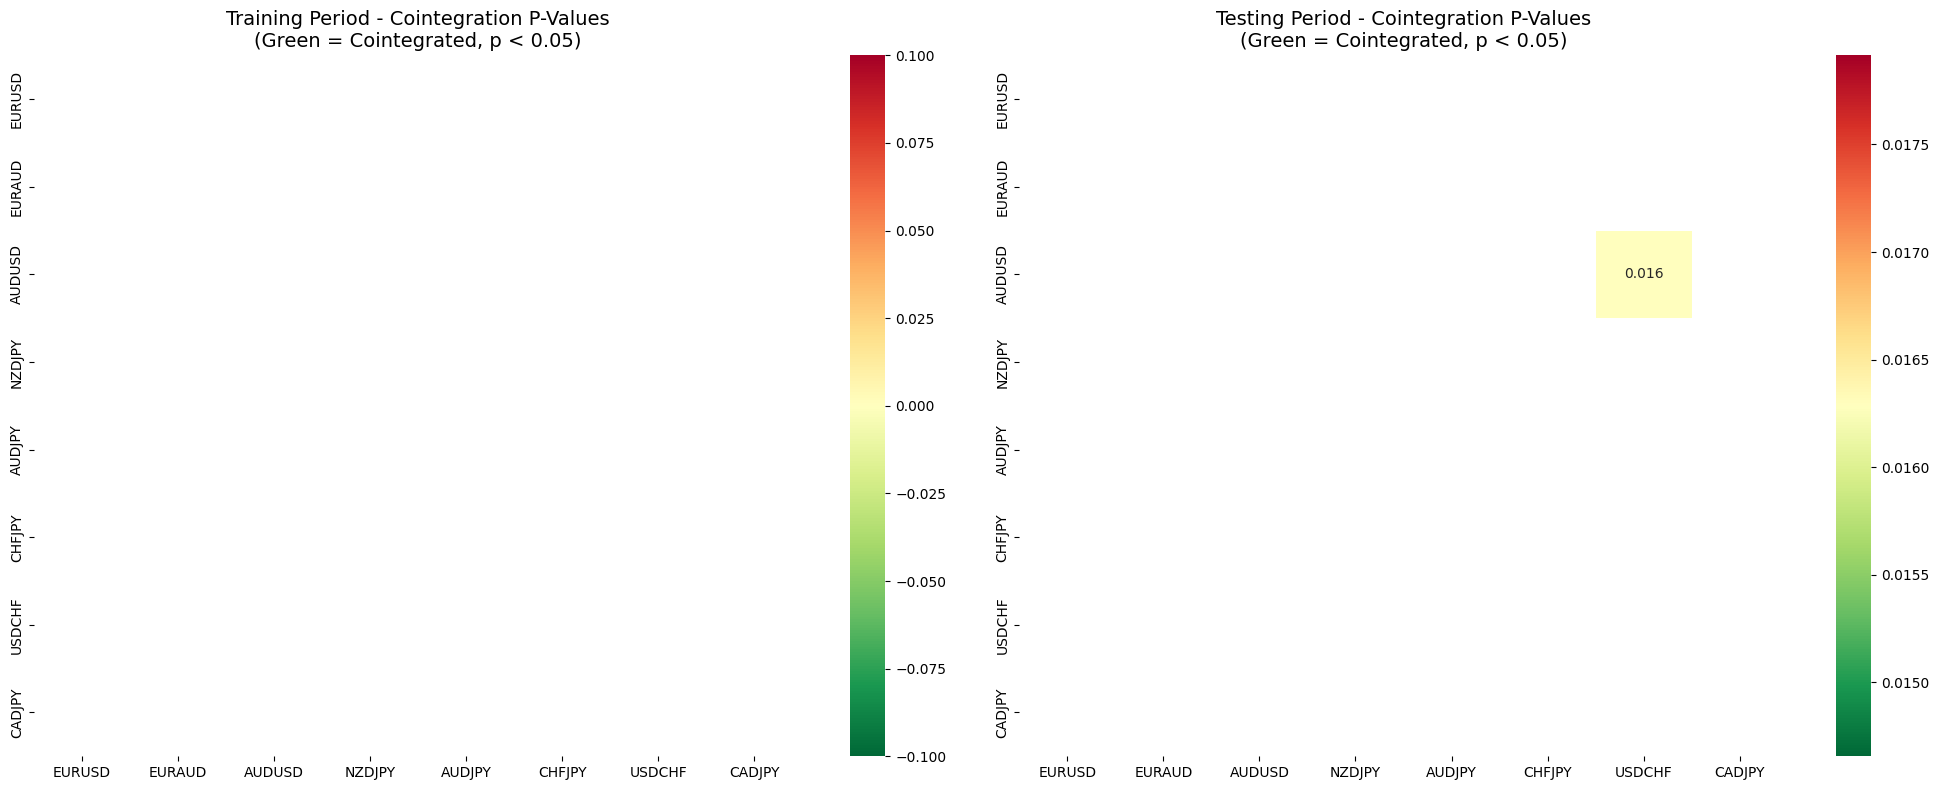

In [103]:
# Visualize cointegration results for TRAINING period
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Training period heatmap
sns.heatmap(
    pvalues_train, 
    xticklabels=[s.replace('=X', '') for s in symbol_list], 
    yticklabels=[s.replace('=X', '') for s in symbol_list], 
    cmap='RdYlGn_r', 
    mask=(pvalues_train >= 0.05),
    ax=axes[0],
    annot=True,
    fmt='.3f'
)
axes[0].set_title('Training Period - Cointegration P-Values\n(Green = Cointegrated, p < 0.05)', fontsize=14)

# Testing period heatmap
sns.heatmap(
    pvalues_test, 
    xticklabels=[s.replace('=X', '') for s in symbol_list], 
    yticklabels=[s.replace('=X', '') for s in symbol_list], 
    cmap='RdYlGn_r', 
    mask=(pvalues_test >= 0.05),
    ax=axes[1],
    annot=True,
    fmt='.3f'
)
axes[1].set_title('Testing Period - Cointegration P-Values\n(Green = Cointegrated, p < 0.05)', fontsize=14)

plt.tight_layout()
plt.show();

In [104]:
# Display training pairs and validation results
print("=== TRAINING PERIOD COINTEGRATED PAIRS ===")
if len(pairs_train) > 0:
    pairs_train_df = pd.DataFrame(pairs_train, columns=['Symbol 1', 'Symbol 2'])
    
    # Get the scores and p-values for the training pairs
    pair_scores_train = []
    pair_pvalues_train = []
    
    for pair in pairs_train:
        symbol1, symbol2 = pair
        # Find the indices of the symbols in the training data columns
        i = list(train_data.columns).index(symbol1)
        j = list(train_data.columns).index(symbol2)
        pair_scores_train.append(scores_train[i, j])
        pair_pvalues_train.append(pvalues_train[i, j])
    
    pairs_train_df['Training Score'] = pair_scores_train
    pairs_train_df['Training P-Value'] = pair_pvalues_train
    pairs_train_df.sort_values(by='Training P-Value', inplace=True)
    
    print(f"Found {len(pairs_train)} cointegrated pairs in training period:")
    print(pairs_train_df)
else:
    print("No cointegrated pairs found in training period with p-value < 0.05")

print(f"\n=== VALIDATION RESULTS ===")
print(f"Consistent pairs (cointegrated in both periods): {len(consistent_pairs)}")
if len(consistent_pairs) > 0:
    print("Best consistent pairs for backtesting:")
    consistent_df = validation_df[validation_df['consistent']].head(3)
    print(consistent_df[['pair', 'train_pvalue', 'test_pvalue']])
else:
    print("No pairs maintained cointegration in testing period")
    print("This suggests overfitting or structural breaks in the relationships")

=== TRAINING PERIOD COINTEGRATED PAIRS ===
No cointegrated pairs found in training period with p-value < 0.05

=== VALIDATION RESULTS ===
Consistent pairs (cointegrated in both periods): 0
No pairs maintained cointegration in testing period
This suggests overfitting or structural breaks in the relationships


In [105]:
# Enhanced Backtesting Framework
# Use parameters estimated from training period and test on out-of-sample data

def estimate_hedge_ratio_and_spread(data, symbol1, symbol2):
    """
    Estimate hedge ratio and calculate spread for a pair
    Returns regression results and spread series
    """
    S1 = data[symbol1]
    S2 = data[symbol2]
    
    # Add constant for regression
    S1_const = sm.add_constant(S1)
    results = sm.OLS(S2, S1_const).fit()
    
    # Get regression coefficient (hedge ratio)
    hedge_ratio = results.params[symbol1]
    intercept = results.params['const']
    
    # Calculate spread
    spread = S2 - hedge_ratio * S1
    
    return {
        'hedge_ratio': hedge_ratio,
        'intercept': intercept,
        'results': results,
        'spread': spread,
        'spread_mean': spread.mean(),
        'spread_std': spread.std()
    }

def backtest_pair_strategy(train_data, test_data, symbol1, symbol2, z_threshold=1.0):
    """
    Backtest a pairs trading strategy:
    1. Estimate parameters on training data
    2. Apply strategy on test data with those parameters
    """
    print(f"\n=== BACKTESTING {symbol1}/{symbol2} ===")
    
    # Step 1: Estimate parameters on training data
    train_params = estimate_hedge_ratio_and_spread(train_data, symbol1, symbol2)
    
    print(f"Training Period Parameters:")
    print(f"  Hedge Ratio: {train_params['hedge_ratio']:.4f}")
    print(f"  R-squared: {train_params['results'].rsquared:.4f}")
    print(f"  Spread Mean: {train_params['spread_mean']:.4f}")
    print(f"  Spread Std: {train_params['spread_std']:.4f}")
    
    # Step 2: Apply strategy on test data using training parameters
    S1_test = test_data[symbol1]
    S2_test = test_data[symbol2]
    
    # Calculate spread using training hedge ratio
    spread_test = S2_test - train_params['hedge_ratio'] * S1_test
    
    # Calculate z-score using training mean and std
    zscore_test = (spread_test - train_params['spread_mean']) / train_params['spread_std']
    
    # Generate trading signals
    signals = pd.DataFrame(index=test_data.index)
    signals['spread'] = spread_test
    signals['zscore'] = zscore_test
    signals['position'] = 0.0
    
    # Long spread when z-score <= -threshold
    signals.loc[signals.zscore <= -z_threshold, 'position'] = 1.0
    # Short spread when z-score >= threshold  
    signals.loc[signals.zscore >= z_threshold, 'position'] = -1.0
    
    # Calculate returns
    signals['spread_returns'] = signals.spread.pct_change()
    signals['strategy_returns'] = signals.spread_returns * signals.position.shift(1)
    signals = signals.dropna()
    
    # Performance metrics
    total_return = signals.strategy_returns.cumsum().iloc[-1]
    sharpe_ratio = signals.strategy_returns.mean() / signals.strategy_returns.std() * np.sqrt(252) if signals.strategy_returns.std() != 0 else 0
    win_rate = (signals[signals.strategy_returns > 0].shape[0] / 
               signals[signals.strategy_returns != 0].shape[0]) if signals[signals.strategy_returns != 0].shape[0] > 0 else 0
    
    print(f"\nOut-of-Sample Test Results:")
    print(f"  Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
    print(f"  Annualized Sharpe: {sharpe_ratio:.4f}")
    print(f"  Win Rate: {win_rate:.2%}")
    print(f"  Number of Trades: {(signals.position != 0).sum()}")
    
    return {
        'signals': signals,
        'train_params': train_params,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate
    }

# Run backtest on the available pair
if 'best_pair' in locals():
    symbol1, symbol2 = best_pair
    
    backtest_results = backtest_pair_strategy(
        train_data, test_data, symbol1, symbol2, z_threshold=1.0
    )
    
    # Add note about pair quality
    if len(pairs_for_backtest) == 0:
        print(f"\n⚠️  WARNING: This pair was not consistently cointegrated across periods")
        print("This is a demonstration of the methodology, not a robust trading signal")
else:
    print("No pairs available for backtesting")
    print("Consider adjusting the cointegration threshold or using different data")


=== BACKTESTING AUDJPY/NZDJPY ===
Training Period Parameters:
  Hedge Ratio: 0.8035
  R-squared: 0.9671
  Spread Mean: 10.6943
  Spread Std: 1.2352

Out-of-Sample Test Results:
  Total Return: 0.3559 (35.59%)
  Annualized Sharpe: 1.1984
  Win Rate: 55.65%
  Number of Trades: 115

⚠️  WARNING: This pair was not consistently cointegrated across periods
This is a demonstration of the methodology, not a robust trading signal


In [106]:
# Visualize backtest results
if len(consistent_pairs) > 0 and 'backtest_results' in locals():
    
    signals = backtest_results['signals']
    train_params = backtest_results['train_params']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Cumulative returns comparison
    cumulative_returns = signals.strategy_returns.cumsum()
    cumulative_returns.plot(ax=axes[0], title=f'Out-of-Sample Backtest: {best_pair[0]}/{best_pair[1]} Strategy Returns', 
                           linewidth=2, color='blue', label='Strategy Returns')
    axes[0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[0].axvline(split_date, color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
    axes[0].set_ylabel('Cumulative Returns')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Z-score and signals
    axes[1].plot(signals.index, signals.zscore, linewidth=1, color='blue', label='Z-Score')
    axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
    axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
    axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1].axvline(split_date, color='red', linestyle='--', alpha=0.7)
    
    # Mark trades
    long_trades = signals[signals.position == 1]
    short_trades = signals[signals.position == -1]
    axes[1].scatter(long_trades.index, long_trades.zscore, color='green', marker='^', s=20, alpha=0.7, label='Long')
    axes[1].scatter(short_trades.index, short_trades.zscore, color='red', marker='v', s=20, alpha=0.7, label='Short')
    
    axes[1].set_title('Trading Signals (Out-of-Sample)')
    axes[1].set_ylabel('Z-Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Spread evolution
    axes[2].plot(train_params['spread'].index, train_params['spread'], 
                linewidth=1, color='gray', alpha=0.7, label='Training Spread')
    axes[2].plot(signals.index, signals.spread, linewidth=1, color='blue', label='Test Spread')
    axes[2].axhline(train_params['spread_mean'], color='black', linestyle='-', alpha=0.7, label='Training Mean')
    axes[2].axhline(train_params['spread_mean'] + train_params['spread_std'], color='red', linestyle='--', alpha=0.5)
    axes[2].axhline(train_params['spread_mean'] - train_params['spread_std'], color='green', linestyle='--', alpha=0.5)
    axes[2].axvline(split_date, color='red', linestyle='--', alpha=0.7)
    
    axes[2].set_title('Spread Evolution')
    axes[2].set_ylabel('Spread')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    summary_stats = pd.DataFrame({
        'Metric': ['Total Return', 'Annualized Sharpe', 'Win Rate', 'Number of Trades', 
                  'Training R²', 'Max Drawdown'],
        'Value': [f"{backtest_results['total_return']:.2%}", 
                 f"{backtest_results['sharpe_ratio']:.3f}",
                 f"{backtest_results['win_rate']:.1%}",
                 f"{(signals.position != 0).sum()}",
                 f"{train_params['results'].rsquared:.3f}",
                 f"{(cumulative_returns - cumulative_returns.expanding().max()).min():.2%}"]
    })
    
    print("\n=== BACKTEST PERFORMANCE SUMMARY ===")
    print(summary_stats.to_string(index=False))

In [107]:
# Pairs Trading Analysis
# AUDJPY/NZDJPY Pair Analysis
# Setup regression and calculate spread

S1 = data['AUDJPY']  # Independent variable
# S2 = data['NZDJPY']  # Dependent variable
S2 = data['NZDJPY']  # Dependent variable

# Add constant for regression
S1_const = sm.add_constant(S1)
results_pair1 = sm.OLS(S2, S1_const).fit()

# Get regression coefficient (hedge ratio)
b_pair1 = results_pair1.params['AUDJPY']
intercept_pair1 = results_pair1.params['const']

# Calculate spread
spread_pair1 = S2 - b_pair1 * S1

print("AUDJPY/NZDJPY Regression Results:")
print(f"Hedge Ratio (beta): {b_pair1:.4f}")
print(f"Intercept: {intercept_pair1:.4f}")
print(f"R-squared: {results_pair1.rsquared:.4f}")
print(f"Spread mean: {spread_pair1.mean():.4f}")
print(f"Spread std: {spread_pair1.std():.4f}")
print("\nRegression Summary:")
print(results_pair1.summary())

AUDJPY/NZDJPY Regression Results:
Hedge Ratio (beta): 0.8182
Intercept: 9.5137
R-squared: 0.9766
Spread mean: 9.5137
Spread std: 1.1934

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                 NZDJPY   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 6.062e+04
Date:                Sun, 10 Aug 2025   Prob (F-statistic):               0.00
Time:                        22:16:37   Log-Likelihood:                -2321.3
No. Observations:                1455   AIC:                             4647.
Df Residuals:                    1453   BIC:                             4657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t

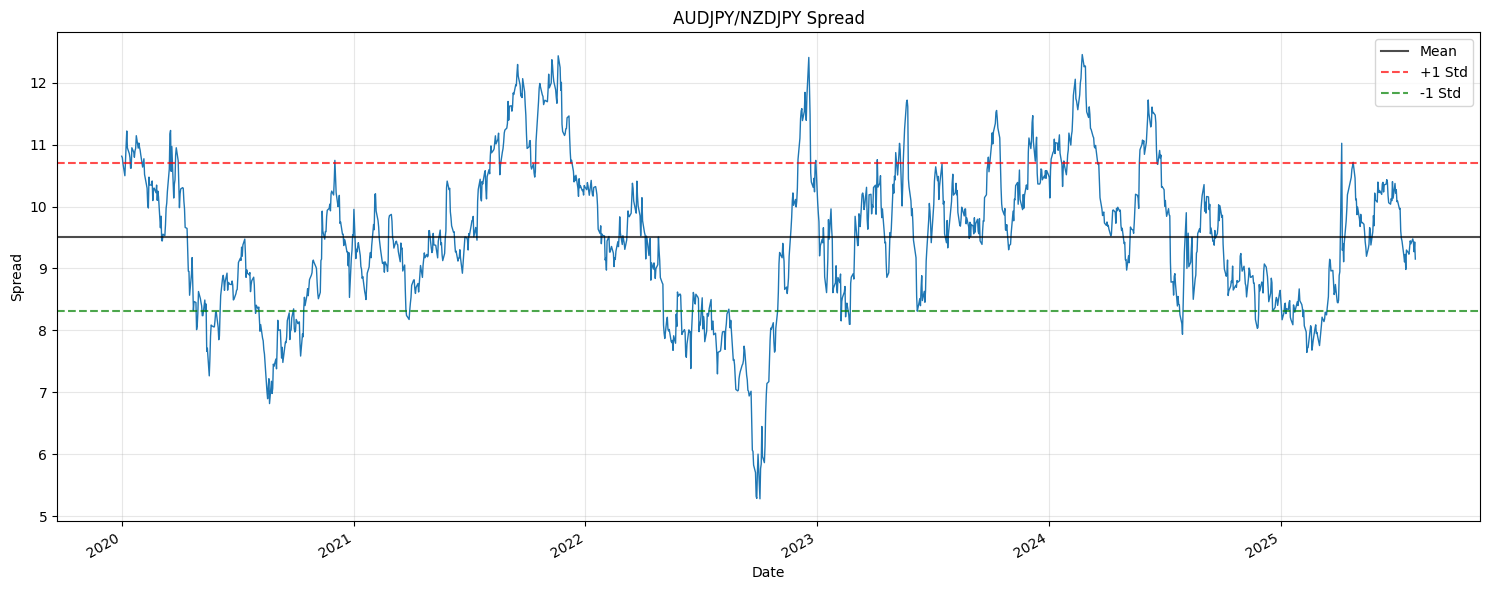

In [108]:
# Plot spread for AUDJPY/NZDJPY
plt.figure(figsize=(15, 6))
spread_pair1.plot(title='AUDJPY/NZDJPY Spread', linewidth=1)
plt.axhline(spread_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(spread_pair1.mean() + spread_pair1.std(), color='red', linestyle='--', alpha=0.7, label='+1 Std')
plt.axhline(spread_pair1.mean() - spread_pair1.std(), color='green', linestyle='--', alpha=0.7, label='-1 Std')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

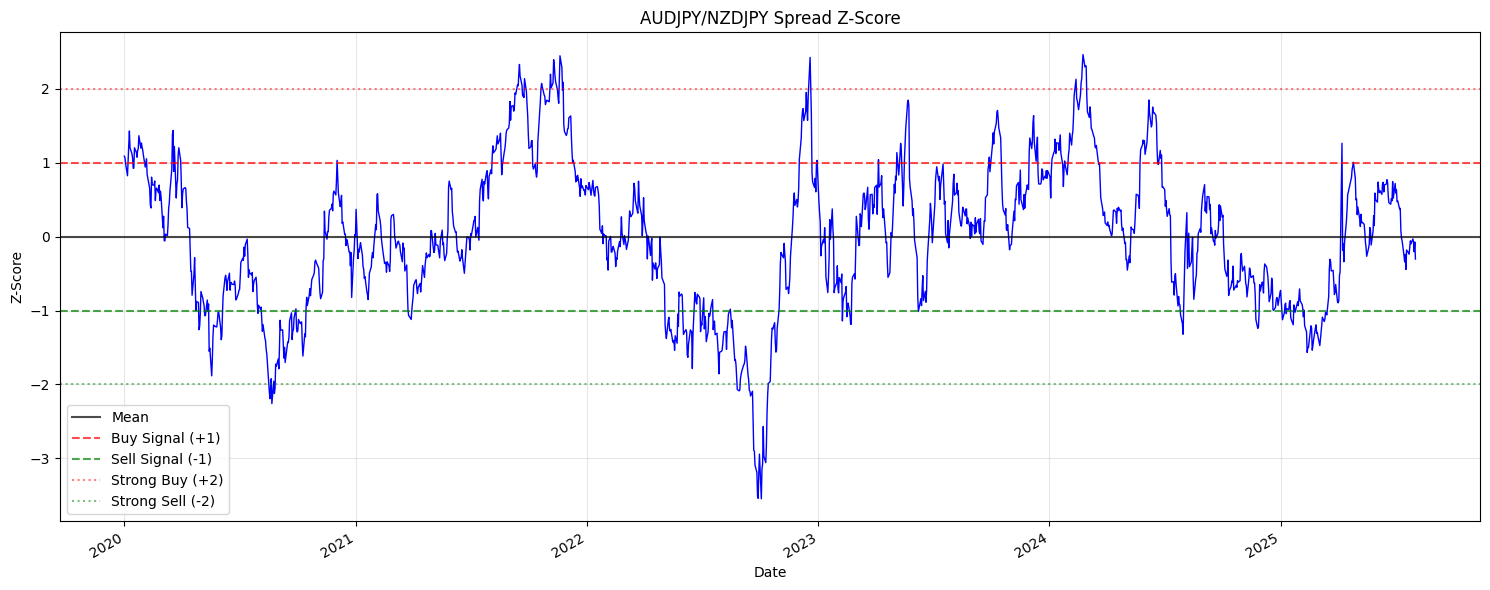

Z-score statistics for AUDJPY/NZDJPY:
Mean: 0.0000
Std: 1.0003
Min: -3.5488
Max: 2.4650


In [109]:
# Z-score calculation and visualization for AUDJPY/CADJPY
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Calculate z-score of spread
zscore_pair1 = zscore(spread_pair1)

# Plot z-score
plt.figure(figsize=(15, 6))
zscore_pair1.plot(title='AUDJPY/NZDJPY Spread Z-Score', linewidth=1, color='blue')
plt.axhline(zscore_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Buy Signal (+1)')
plt.axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Sell Signal (-1)')
plt.axhline(2.0, color='red', linestyle=':', alpha=0.5, label='Strong Buy (+2)')
plt.axhline(-2.0, color='green', linestyle=':', alpha=0.5, label='Strong Sell (-2)')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Z-score statistics for AUDJPY/NZDJPY:")
print(f"Mean: {zscore_pair1.mean():.4f}")
print(f"Std: {zscore_pair1.std():.4f}")
print(f"Min: {zscore_pair1.min():.4f}")
print(f"Max: {zscore_pair1.max():.4f}")

In [110]:
# Trading Strategy for AUDJPY/NZDJPY
# Create DataFrame with signal and position

trades_pair1 = pd.DataFrame({
    'signal': zscore_pair1,
    'position': spread_pair1,
    'AUDJPY': S1,
    'NZDJPY': S2
})

# Add trading side based on z-score thresholds
trades_pair1['side'] = 0.0
trades_pair1.loc[trades_pair1.signal <= -1, 'side'] = 1.0   # Long spread when z-score <= -1
trades_pair1.loc[trades_pair1.signal >= 1, 'side'] = -1.0   # Short spread when z-score >= 1

# Calculate position changes and returns
trades_pair1['position_change'] = trades_pair1.position.pct_change()
trades_pair1['strategy_returns'] = trades_pair1.position_change * trades_pair1.side.shift(1)

# Remove NaN values
trades_pair1 = trades_pair1.dropna()

print("AUDJPY/NZDJPY Trading Signals Summary:")
print(f"Total trading signals: {(trades_pair1.side != 0).sum()}")
print(f"Long signals: {(trades_pair1.side == 1).sum()}")
print(f"Short signals: {(trades_pair1.side == -1).sum()}")
print(f"Signal ratio: {(trades_pair1.side != 0).mean():.2%}")

# Display first few trades
print("\nFirst 10 trading signals:")
signal_trades = trades_pair1[trades_pair1.side != 0].head(10)
print(signal_trades[['signal', 'side', 'strategy_returns']])

AUDJPY/NZDJPY Trading Signals Summary:
Total trading signals: 463
Long signals: 235
Short signals: 228
Signal ratio: 31.84%

First 10 trading signals:
              signal  side  strategy_returns
Date                                        
2020-01-02  1.069481  -1.0          0.002153
2020-01-07  1.040947  -1.0          0.000000
2020-01-08  1.243771  -1.0         -0.022497
2020-01-09  1.430277  -1.0         -0.020232
2020-01-10  1.200599  -1.0          0.024421
2020-01-13  1.123003  -1.0          0.008457
2020-01-14  1.070109  -1.0          0.005814
2020-01-17  1.203078  -1.0          0.000000
2020-01-20  1.141703  -1.0          0.006687
2020-01-21  1.074838  -1.0          0.007335


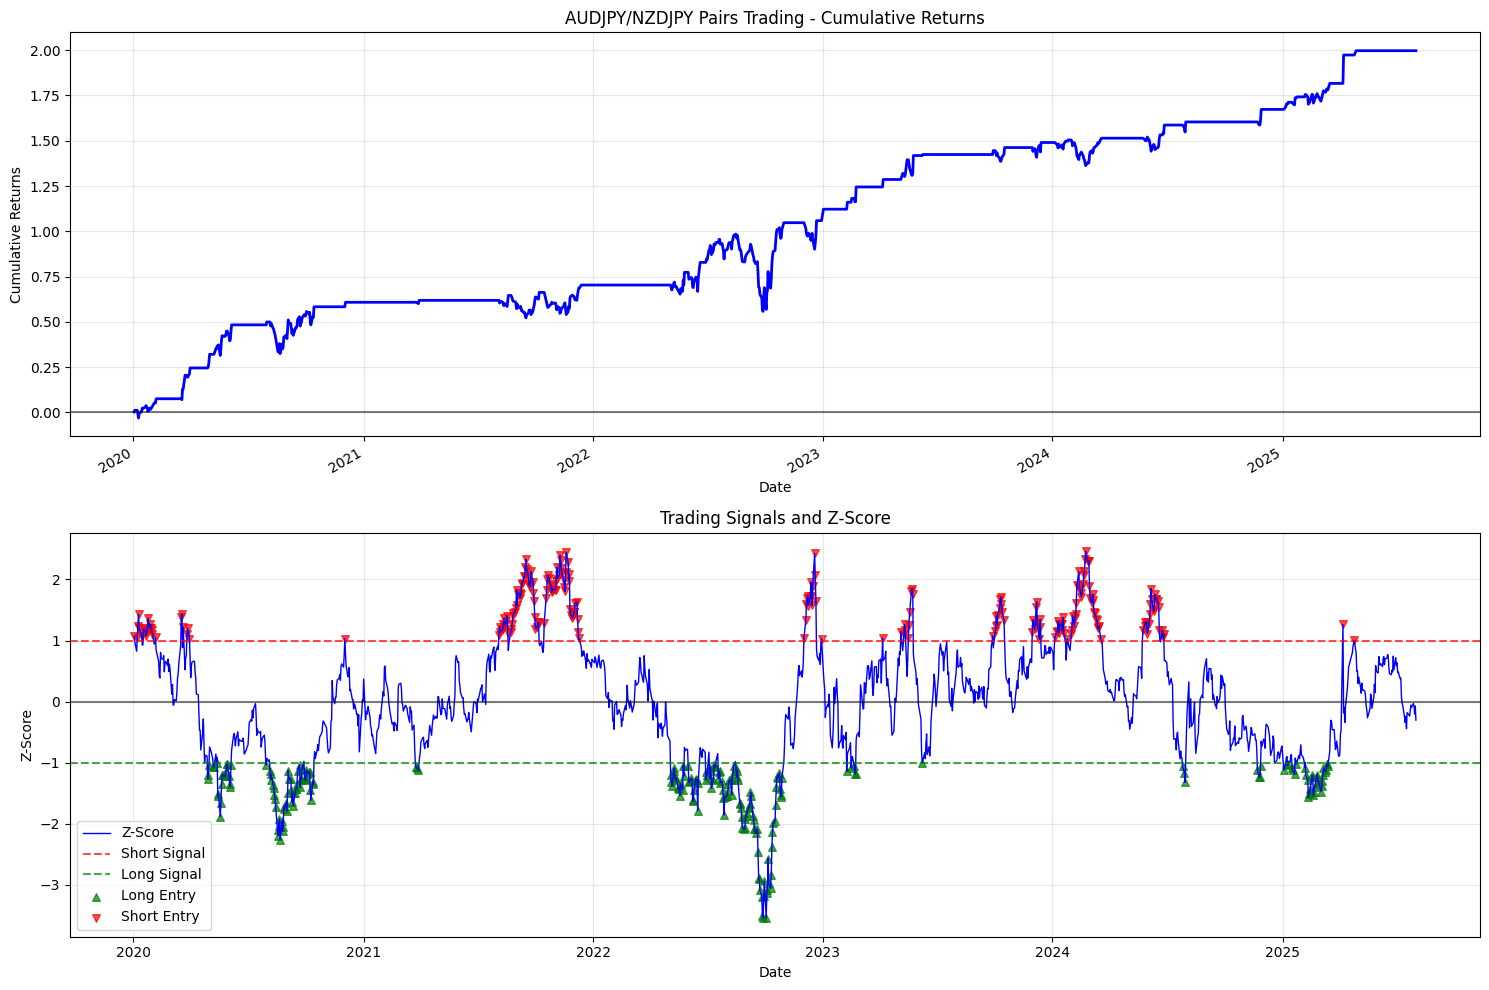


AUDJPY/NZDJPY Strategy Performance:
Total Return: 1.9973 (199.73%)
Annualized Sharpe Ratio: 1.3457
Maximum Drawdown: -0.4262 (-42.62%)


In [111]:
# Plot strategy performance for AUDJPY/NZDJPY
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot cumulative returns
cumulative_returns_pair1 = trades_pair1.strategy_returns.cumsum()
cumulative_returns_pair1.plot(ax=axes[0], title='AUDJPY/NZDJPY Pairs Trading - Cumulative Returns', 
                              linewidth=2, color='blue')
axes[0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0].set_ylabel('Cumulative Returns')
axes[0].grid(True, alpha=0.3)

# Plot signals with z-score
axes[1].plot(trades_pair1.index, trades_pair1.signal, linewidth=1, color='blue', label='Z-Score')
axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)

# Mark actual trades
long_trades = trades_pair1[trades_pair1.side == 1]
short_trades = trades_pair1[trades_pair1.side == -1]
axes[1].scatter(long_trades.index, long_trades.signal, color='green', marker='^', s=30, alpha=0.7, label='Long Entry')
axes[1].scatter(short_trades.index, short_trades.signal, color='red', marker='v', s=30, alpha=0.7, label='Short Entry')

axes[1].set_title('Trading Signals and Z-Score')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics
total_return = cumulative_returns_pair1.iloc[-1]
sharpe_ratio = trades_pair1.strategy_returns.mean() / trades_pair1.strategy_returns.std() * np.sqrt(252)
max_drawdown = (cumulative_returns_pair1 - cumulative_returns_pair1.expanding().max()).min()

print(f"\nAUDJPY/NZDJPY Strategy Performance:")
print(f"Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")

In [112]:
# CADJPY/NZDJPY Pair Analysis
# Setup regression and calculate spread

S1_pair2 = data['CADJPY']  # Independent variable
S2_pair2 = data['NZDJPY']  # Dependent variable

# Add constant for regression
S1_const_pair2 = sm.add_constant(S1_pair2)
results_pair2 = sm.OLS(S2_pair2, S1_const_pair2).fit()

# Get regression coefficient (hedge ratio)
b_pair2 = results_pair2.params['CADJPY']
intercept_pair2 = results_pair2.params['const']

# Calculate spread
spread_pair2 = S2_pair2 - b_pair2 * S1_pair2

print("CADJPY/NZDJPY Regression Results:")
print(f"Hedge Ratio (beta): {b_pair2:.4f}")
print(f"Intercept: {intercept_pair2:.4f}")
print(f"R-squared: {results_pair2.rsquared:.4f}")
print(f"Spread mean: {spread_pair2.mean():.4f}")
print(f"Spread std: {spread_pair2.std():.4f}")
print("\nRegression Summary:")
print(results_pair2.summary())

CADJPY/NZDJPY Regression Results:
Hedge Ratio (beta): 0.6433
Intercept: 19.3954
R-squared: 0.9375
Spread mean: 19.3954
Spread std: 1.9498

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                 NZDJPY   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 2.180e+04
Date:                Sun, 10 Aug 2025   Prob (F-statistic):               0.00
Time:                        22:16:39   Log-Likelihood:                -3035.6
No. Observations:                1455   AIC:                             6075.
Df Residuals:                    1453   BIC:                             6086.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>

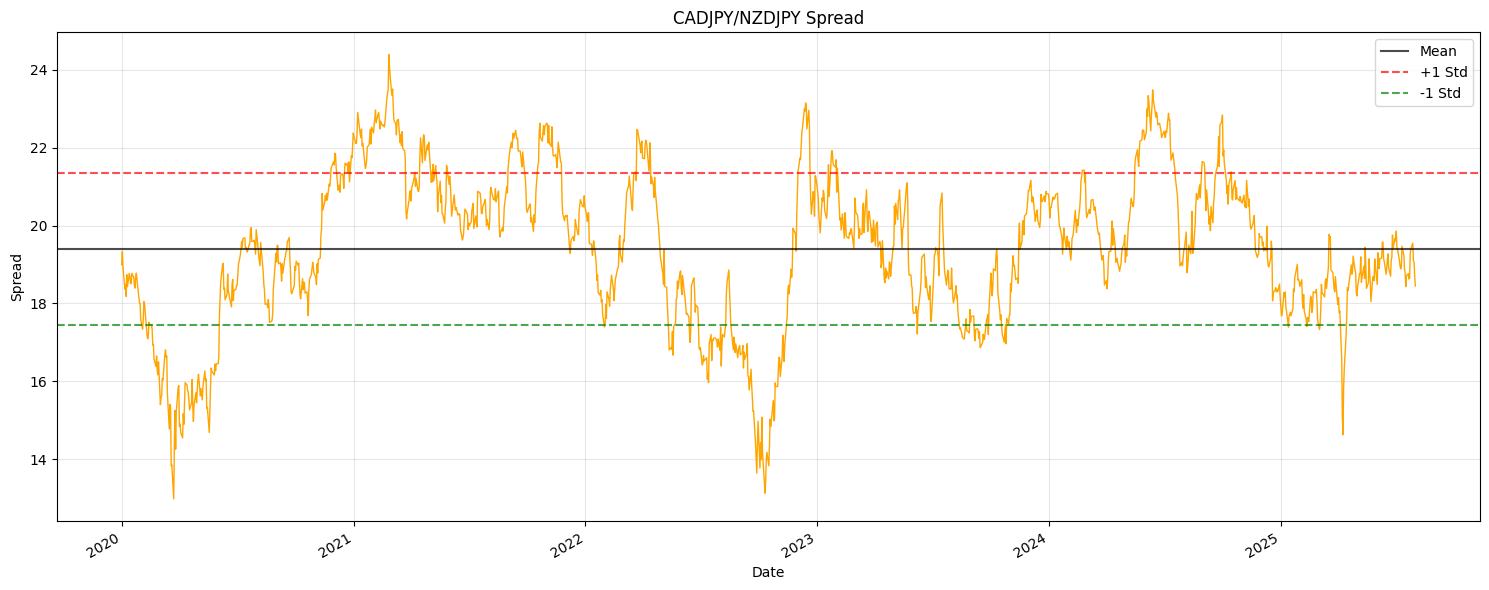

In [113]:
# Plot spread for CADJPY/NZDJPY
plt.figure(figsize=(15, 6))
spread_pair2.plot(title='CADJPY/NZDJPY Spread', linewidth=1, color='orange')
plt.axhline(spread_pair2.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(spread_pair2.mean() + spread_pair2.std(), color='red', linestyle='--', alpha=0.7, label='+1 Std')
plt.axhline(spread_pair2.mean() - spread_pair2.std(), color='green', linestyle='--', alpha=0.7, label='-1 Std')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

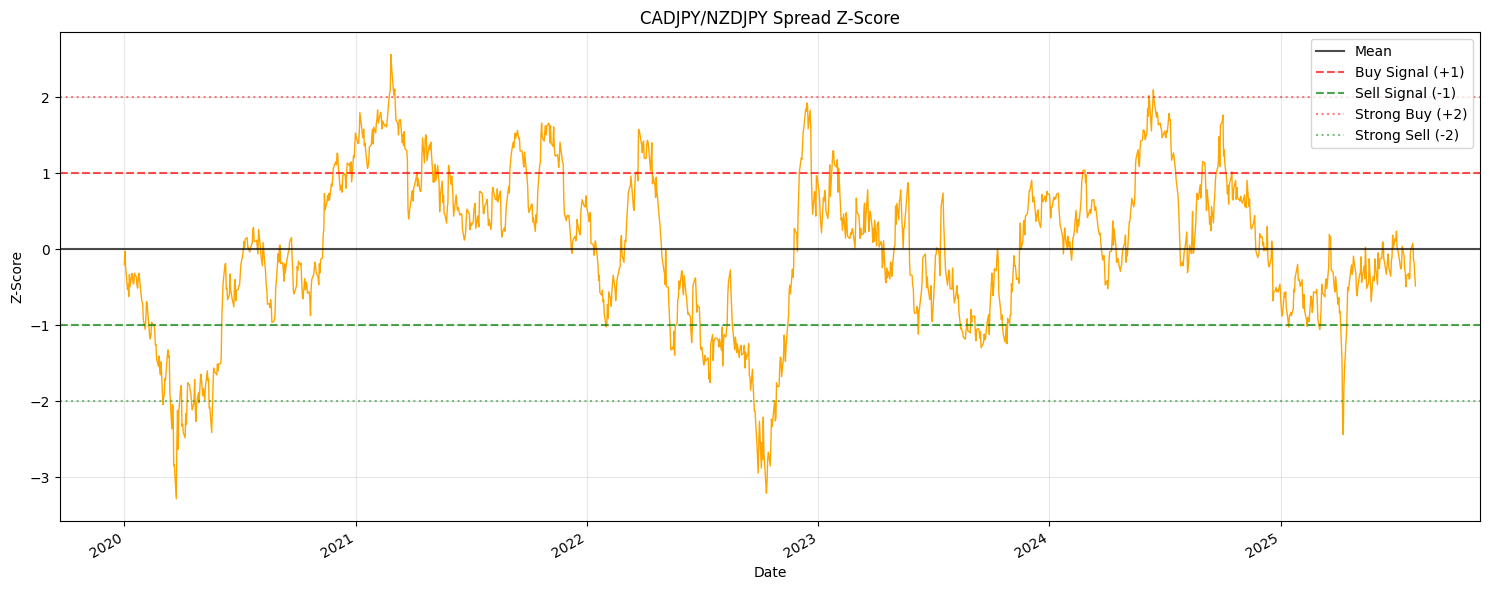

Z-score statistics for CADJPY/NZDJPY:
Mean: -0.0000
Std: 1.0003
Min: -3.2872
Max: 2.5604


In [114]:
# Z-score calculation and visualization for CADJPY/NZDJPY
# Calculate z-score of spread
zscore_pair2 = zscore(spread_pair2)

# Plot z-score
plt.figure(figsize=(15, 6))
zscore_pair2.plot(title='CADJPY/NZDJPY Spread Z-Score', linewidth=1, color='orange')
plt.axhline(zscore_pair2.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Buy Signal (+1)')
plt.axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Sell Signal (-1)')
plt.axhline(2.0, color='red', linestyle=':', alpha=0.5, label='Strong Buy (+2)')
plt.axhline(-2.0, color='green', linestyle=':', alpha=0.5, label='Strong Sell (-2)')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Z-score statistics for CADJPY/NZDJPY:")
print(f"Mean: {zscore_pair2.mean():.4f}")
print(f"Std: {zscore_pair2.std():.4f}")
print(f"Min: {zscore_pair2.min():.4f}")
print(f"Max: {zscore_pair2.max():.4f}")

In [115]:
# Trading Strategy for CADJPY/NZDJPY
# Create DataFrame with signal and position

trades_pair2 = pd.DataFrame({
    'signal': zscore_pair2,
    'position': spread_pair2,
    'CADJPY': S1_pair2,
    'NZDJPY': S2_pair2
})

# Add trading side based on z-score thresholds
trades_pair2['side'] = 0.0
trades_pair2.loc[trades_pair2.signal <= -1, 'side'] = 1.0   # Long spread when z-score <= -1
trades_pair2.loc[trades_pair2.signal >= 1, 'side'] = -1.0   # Short spread when z-score >= 1

# Calculate position changes and returns
trades_pair2['position_change'] = trades_pair2.position.pct_change()
trades_pair2['strategy_returns'] = trades_pair2.position_change * trades_pair2.side.shift(1)

# Remove NaN values
trades_pair2 = trades_pair2.dropna()

print("CADJPY/NZDJPY Trading Signals Summary:")
print(f"Total trading signals: {(trades_pair2.side != 0).sum()}")
print(f"Long signals: {(trades_pair2.side == 1).sum()}")
print(f"Short signals: {(trades_pair2.side == -1).sum()}")
print(f"Signal ratio: {(trades_pair2.side != 0).mean():.2%}")

# Display first few trades
print("\nFirst 10 trading signals:")
signal_trades_pair2 = trades_pair2[trades_pair2.side != 0]
print(signal_trades_pair2[['signal', 'side', 'strategy_returns']].head(10))

CADJPY/NZDJPY Trading Signals Summary:
Total trading signals: 463
Long signals: 223
Short signals: 240
Signal ratio: 31.84%

First 10 trading signals:
              signal  side  strategy_returns
Date                                        
2020-02-03 -1.055881   1.0         -0.000000
2020-02-10 -1.145312   1.0         -0.000000
2020-02-11 -1.181167   1.0         -0.004072
2020-02-12 -1.131599   1.0          0.005652
2020-02-17 -1.001003   1.0         -0.000000
2020-02-18 -1.059038   1.0         -0.006484
2020-02-19 -1.263848   1.0         -0.023033
2020-02-20 -1.253901   1.0          0.001145
2020-02-21 -1.450254   1.0         -0.022577
2020-02-24 -1.545916   1.0         -0.011253


In [116]:
signal_trades_pair2.tail()

,signal,position,CADJPY,NZDJPY,side,position_change,strategy_returns
Date,,,,,,,
2025-04-08,-2.230330,15.048290,103.781998,81.811996,1.0,-0.091560,-0.091560
2025-04-09,-2.442325,14.635094,102.318001,80.457001,1.0,-0.027458,-0.027458
2025-04-10,-1.822501,15.843182,104.504997,83.071999,1.0,0.082547,0.082547
2025-04-11,-1.571491,16.332420,103.016998,82.603996,1.0,0.030880,0.030880
2025-04-14,-1.115577,17.221033,103.556999,83.839996,1.0,0.054408,0.054408


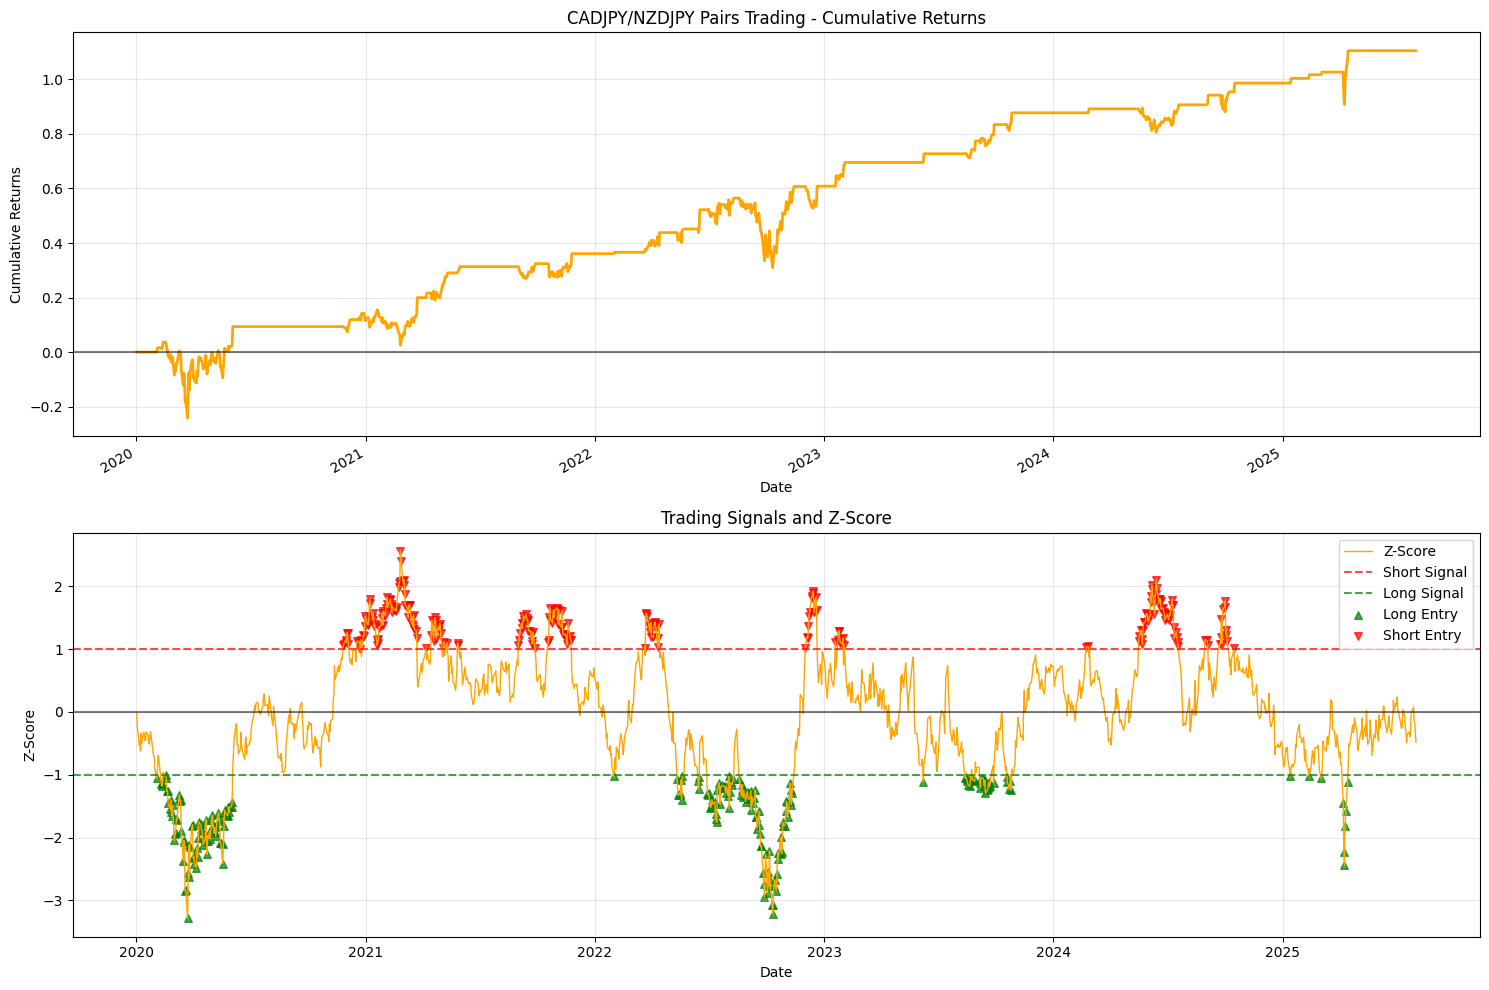


CADJPY/NZDJPY Strategy Performance:
Total Return: 1.1054 (110.54%)
Annualized Sharpe Ratio: 0.8888
Maximum Drawdown: -0.2783 (-27.83%)


In [117]:
# Plot strategy performance for CADJPY/NZDJPY
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot cumulative returns
cumulative_returns_pair2 = trades_pair2.strategy_returns.cumsum()
cumulative_returns_pair2.plot(ax=axes[0], title='CADJPY/NZDJPY Pairs Trading - Cumulative Returns', 
                              linewidth=2, color='orange')
axes[0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0].set_ylabel('Cumulative Returns')
axes[0].grid(True, alpha=0.3)

# Plot signals with z-score
axes[1].plot(trades_pair2.index, trades_pair2.signal, linewidth=1, color='orange', label='Z-Score')
axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)

# Mark actual trades
long_trades_pair2 = trades_pair2[trades_pair2.side == 1]
short_trades_pair2 = trades_pair2[trades_pair2.side == -1]
axes[1].scatter(long_trades_pair2.index, long_trades_pair2.signal, color='green', marker='^', s=30, alpha=0.7, label='Long Entry')
axes[1].scatter(short_trades_pair2.index, short_trades_pair2.signal, color='red', marker='v', s=30, alpha=0.7, label='Short Entry')

axes[1].set_title('Trading Signals and Z-Score')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics
total_return_pair2 = cumulative_returns_pair2.iloc[-1]
sharpe_ratio_pair2 = trades_pair2.strategy_returns.mean() / trades_pair2.strategy_returns.std() * np.sqrt(252)
max_drawdown_pair2 = (cumulative_returns_pair2 - cumulative_returns_pair2.expanding().max()).min()

print(f"\nCADJPY/NZDJPY Strategy Performance:")
print(f"Total Return: {total_return_pair2:.4f} ({total_return_pair2*100:.2f}%)")
print(f"Annualized Sharpe Ratio: {sharpe_ratio_pair2:.4f}")
print(f"Maximum Drawdown: {max_drawdown_pair2:.4f} ({max_drawdown_pair2*100:.2f}%)")